# Распознавание именованных сущностей
*Обучение модели*

## Определение классов

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from datasets import (
    load_dataset,
    concatenate_datasets,
    DatasetDict,
    Dataset,
    ClassLabel,
)
from torch.utils.data import DataLoader
from transformers import (
    pipeline,
    Pipeline,
    AutoTokenizer,
    XLMRobertaConfig,
    RobertaModel,
    RobertaPreTrainedModel,
    DataCollatorForTokenClassification,
    get_scheduler,
)
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.pipelines.token_classification import AggregationStrategy
from seqeval.metrics import f1_score
from torchmetrics import Metric
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from pathlib import Path
from collections import defaultdict
from typing import Literal
from contextlib import contextmanager


@contextmanager
def disable_tokenizer_parallelism():
    original_value = os.environ.get("TOKENIZERS_PARALLELISM")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    try:
        yield
    finally:
        if original_value is not None:
            os.environ["TOKENIZERS_PARALLELISM"] = original_value
        else:
            os.environ.pop("TOKENIZERS_PARALLELISM", None)


class PANXDataModule(pl.LightningDataModule):
    def __init__(
        self,
        model_name: str = "xlm-roberta-base",
        langs: list = ["de", "fr", "it", "en"],
        train_langs: list = ["de"],
        fracs: list = [0.629, 0.229, 0.084, 0.059],
        batch_size: int = 24,
        num_workers: int = 4,
    ):
        super().__init__()

        self.model_name = model_name
        self.tokenizer: AutoTokenizer = None
        self.data_collator: DataCollatorForTokenClassification = None

        self.langs = langs
        self.train_langs = train_langs.copy()
        self.fracs = fracs

        self.panx_ch = defaultdict(DatasetDict)
        self.panx_tokenized = defaultdict(DatasetDict)
        self.dataset: DatasetDict = None
        self.tags: ClassLabel = None  # Метки (B-ORG, I-ORG, ...)

        self.batch_size = batch_size
        self.num_workers = num_workers

        self._is_setuped = False

    def prepare_data(self):
        for lang in self.langs:
            load_dataset("xtreme", name=f"PAN-X.{lang}")
        AutoTokenizer.from_pretrained(self.model_name)

    def setup(self, stage: str | None = None):
        if self._is_setuped:
            return
        # Загрузка токенизатора
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.data_collator = DataCollatorForTokenClassification(self.tokenizer)

        # Загрузка датасетов согласно их частотам
        for lang, frac in zip(self.langs, self.fracs):
            ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
            for split in ds:
                self.panx_ch[lang][split] = (
                    ds[split]
                    .shuffle(42)
                    .select(range(int(frac * ds[split].num_rows)))
                )

        # tags
        self.tags = (
            self.panx_ch[self.langs[0]]["train"].features["ner_tags"].feature
        )

        # tokenizig
        for lang in self.langs:
            self.panx_tokenized[lang] = self.tokenize_panx_dataset(
                self.panx_ch[lang]
            )
        self._is_setuped = True

    def set_train_langs(self, train_langs: list[str]):
        self.train_langs = train_langs.copy()

    def train_dataloader(self):
        dataset = self.concat_datasets(
            [self.panx_tokenized[lang] for lang in self.train_langs], "train"
        )
        return DataLoader(
            dataset["train"],
            self.batch_size,
            shuffle=True,
            collate_fn=self.data_collator,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        dataloaders = []

        for lang in self.langs:
            dataset = self.panx_tokenized[lang]["validation"]
            dataloader = DataLoader(
                dataset,
                self.batch_size,
                shuffle=False,
                collate_fn=self.data_collator,
                num_workers=self.num_workers,
            )
            dataloaders.append(dataloader)

        return dataloaders

    def test_dataloader(self):
        dataloaders = []

        for lang in self.langs:
            dataset = self.panx_tokenized[lang]["test"]
            dataloader = DataLoader(
                dataset,
                self.batch_size,
                shuffle=False,
                collate_fn=self.data_collator,
                num_workers=self.num_workers,
            )
            dataloaders.append(dataloader)

        return dataloaders

    def tokenize_and_align_labels(self, examples):
        tokenized_inputs = self.tokenizer(
            examples["tokens"], truncation=True, is_split_into_words=True
        )

        labels = []
        for idx, label in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=idx)
            prev_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None or word_idx == prev_word_idx:
                    label_ids.append(-100)
                else:
                    label_ids.append(label[word_idx])
                prev_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    def tokenize_panx_dataset(self, corpus: DatasetDict):
        return corpus.map(
            self.tokenize_and_align_labels,
            batched=True,
            remove_columns=["langs", "ner_tags", "tokens"],
        )

    # PANXDataModule.concatenate_datasets() takes 2 positional arguments but 3 were given
    def concat_datasets(
        self,
        corpora: list[DatasetDict],
        split: Literal["train", "validation", "test"],
    ) -> DatasetDict:
        multi_corpus = DatasetDict()
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)
        return multi_corpus


class SeqevalF1Metric(Metric):
    def __init__(
        self,
        id2label: dict[int, str],
        average: Literal[None, "micro", "macro", "weighted"] = "micro",
    ):
        super().__init__()
        self.id2label = id2label
        self.average = average
        self.add_state(
            "total_f1", default=torch.tensor(0.0), dist_reduce_fx="sum"
        )
        self.add_state(
            "total_batches", default=torch.tensor(0), dist_reduce_fx="sum"
        )

    def update(self, predictions: torch.Tensor, label_ids: torch.Tensor):
        preds_list, labels_list = self._align_predictions(
            predictions, label_ids
        )
        self.total_f1 += f1_score(
            labels_list, preds_list, average=self.average
        )
        self.total_batches += 1

    def compute(self):
        if self.total_batches == 0:
            return 0
        return self.total_f1 / self.total_batches

    def _align_predictions(
        self, predictions: torch.Tensor, label_ids: torch.Tensor
    ) -> tuple[list[list], list[list]]:
        # predictions, labels_ids: (batch_size, seq_len)
        predictions_cpu = predictions.cpu().numpy()
        label_ids_cpu = label_ids.cpu().numpy()

        batch_size, seq_len = predictions_cpu.shape
        labels_list, preds_list = [], []

        for batch_idx in range(batch_size):
            example_labels, example_preds = [], []
            for seq_idx in range(seq_len):
                if label_ids[batch_idx, seq_idx] != -100:
                    example_labels.append(
                        self.id2label[label_ids_cpu[batch_idx, seq_idx]]
                    )
                    example_preds.append(
                        self.id2label[predictions_cpu[batch_idx][seq_idx]]
                    )
            labels_list.append(example_labels)
            preds_list.append(example_preds)

        return preds_list, labels_list


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs,
    ):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs,
        )
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


class plNERClassifier(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        config: XLMRobertaConfig,
        langs: list,
        lr: float = 1e-4,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.langs = langs
        self.config = config
        self.lr = lr
        self.model = XLMRobertaForTokenClassification.from_pretrained(
            model_name, config=config
        )

        self.train_f1 = SeqevalF1Metric(config.id2label, average="micro")

        for lang in self.langs:
            setattr(
                self,
                f"val_f1_{lang}",
                SeqevalF1Metric(config.id2label, average="micro"),
            )

    def forward(self, batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        output = self(batch)
        logits, loss = output.logits, output.loss

        self.train_f1.update(torch.argmax(logits, dim=-1), batch["labels"])

        self.log(
            "train_loss", loss, prog_bar=True, on_step=False, on_epoch=True
        )
        self.log(
            "train_f1",
            self.train_f1,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
        )

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        lang = self.langs[dataloader_idx]
        metric_name = f"val_f1_{lang}"

        output = self(batch)
        logits, loss = output.logits, output.loss

        metric = getattr(self, metric_name)
        metric.update(torch.argmax(logits, dim=-1), batch["labels"])

        self.log(
            f"val_loss_{lang}",
            loss,
            prog_bar=False,
            on_step=False,
            on_epoch=True,
            add_dataloader_idx=False,
        )

        self.log(
            metric_name,
            metric,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            metric_attribute=metric_name,
            add_dataloader_idx=False,
        )
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        num_training_steps = self.trainer.estimated_stepping_batches
        num_warmup_steps = int(0.1 * num_training_steps)
        scheduler = get_scheduler(
            "linear",
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }


class NERPredictor:
    def __init__(
        self,
        model: XLMRobertaForTokenClassification,
        tokenizer: AutoTokenizer,
        device: torch.device = "cuda",
    ):
        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.device = device

    def pipeline(self, device: torch.device = "cuda") -> Pipeline:
        return pipeline(
            "token-classification",
            model=self.model,
            tokenizer=self.tokenizer,
            device=torch.device(
                device if torch.cuda.is_available() else "cpu"
            ),
        )

    @torch.inference_mode
    def tag_text(self, text: str) -> pd.DataFrame:
        tokenized = self.tokenizer(text, return_tensors="pt")
        tokens = tokenized.tokens()
        input_ids = tokenized.input_ids.to(self.device)
        logits = self.model(input_ids).logits
        predictions = torch.argmax(logits, dim=2)
        preds = [
            self.model.config.id2label[p] for p in predictions[0].cpu().numpy()
        ]
        return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

    @torch.inference_mode()
    def compute_loss_foreach_token(self, dataloader: DataLoader) -> Dataset:
        device = self.device
        model = self.model
        tokenizer = self.tokenizer
        id2label = model.config.id2label.copy()
        id2label[-100] = "IGN"
        num_labels = model.config.num_labels

        def data_generator():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                losses = F.cross_entropy(
                    logits.view(-1, num_labels),
                    labels.view(-1),
                    reduction="none",
                ).view(labels.shape)

                preds = torch.argmax(logits, dim=-1)

                input_ids = input_ids.cpu().numpy()
                labels = labels.cpu().numpy()
                preds = preds.cpu().numpy()
                losses = losses.cpu().numpy()

                for i in range(input_ids.shape[0]):
                    tokens = tokenizer.convert_ids_to_tokens(
                        input_ids[i].tolist()
                    )
                    true_labels = [
                        id2label.get(int(l), "UNK") for l in labels[i]
                    ]
                    pred_labels = [
                        id2label.get(int(p), "UNK") for p in preds[i]
                    ]
                    token_losses = losses[i].astype(float).tolist()

                    yield {
                        "tokens": tokens,
                        "true_labels": true_labels,
                        "pred_labels": pred_labels,
                        "token_losses": token_losses,
                    }

        # динамическое создание Dataset без предварительного списка
        dataset = Dataset.from_generator(data_generator)
        return dataset


def get_metrics(path: Path):
    df = pd.read_csv(path)
    df = (
        df[df["epoch"] == df["epoch"].max()]
        .drop("step", axis=1)
        .groupby("epoch")
        .last()
    )
    return df

/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "xlm-roberta-base"
LANGS = ["de", "fr", "it", "en"]
TRAIN_LANGS = ["de"]
FRACS = [0.629, 0.229, 0.084, 0.059]
BATCH_SIZE = 24
NUM_WORKERS = 4

NUM_EPOCHS = 5

EXPERIMENTS_PATH = Path("NER")


def get_trainer(train_langs: list[str]) -> pl.Trainer:
    experiment_path = Path(EXPERIMENTS_PATH, "-".join(train_langs))
    CHECKPOINT_PATH = experiment_path / "checkpoints"
    CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

    callbacks = [
        TQDMProgressBar(leave=True),
        ModelCheckpoint(
            dirpath=CHECKPOINT_PATH,
            filename="last",
            save_last=True,
            save_top_k=0,
        ),
    ]
    logger = CSVLogger(save_dir=experiment_path, name="logs")
    last_ckpt_path = CHECKPOINT_PATH / "last.ckpt"
    ckpt_path = last_ckpt_path if last_ckpt_path.exists() else None

    trainer = pl.Trainer(
        max_epochs=NUM_EPOCHS,
        devices=1,
        callbacks=callbacks,
        logger=logger if not ckpt_path else False,
    )
    return trainer, ckpt_path

In [3]:
dm = PANXDataModule(
    MODEL_NAME, LANGS, TRAIN_LANGS, FRACS, BATCH_SIZE, NUM_WORKERS
)
dm.prepare_data()
dm.setup()

Map: 100%|██████████| 590/590 [00:00<00:00, 30158.30 examples/s]


In [4]:
id2label = {idx: tag for idx, tag in enumerate(dm.tags.names)}
label2id = {tag: idx for idx, tag in id2label.items()}

xlmr_config = XLMRobertaConfig.from_pretrained(
    MODEL_NAME, num_labels=len(id2label), id2label=id2label, label2id=label2id
)

## Обучение только на немецком датасете

In [5]:
pl_model = plNERClassifier(
    model_name=MODEL_NAME,
    config=xlmr_config,
    langs=LANGS,
    lr=2e-5,
)

trainer, ckpt_path = get_trainer(TRAIN_LANGS)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
with disable_tokenizer_parallelism():
    trainer.fit(pl_model, datamodule=dm, ckpt_path=ckpt_path)
    if ckpt_path:
        print(f"\nМодель загружена из памяти {ckpt_path}")

You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at NER/de/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | XLMRobertaForTokenClassification | 277 M  | eval 
1 | train_f1  | SeqevalF1Metric                  | 0      | train
2 | val_f1_de | SeqevalF1Metric                  | 0      | train
3 | val_f1_fr | SeqevalF1Metric                  | 0      | train
4 | val_f1_it | SeqevalF1Metric                

`Trainer.fit` stopped: `max_epochs=5` reached.



Модель загружена из памяти NER/de/checkpoints/last.ckpt


In [7]:
results = get_metrics(EXPERIMENTS_PATH / "de/logs/version_0/metrics.csv")
results

,train_f1,train_loss,val_f1_de,val_f1_en,val_f1_fr,val_f1_it,val_loss_de,val_loss_en,val_loss_fr,val_loss_it
epoch,,,,,,,,,,
4,0.973679,0.019325,0.86197,0.585224,0.702495,0.628935,0.143299,0.974609,0.869035,1.038661


In [8]:
predictor = NERPredictor(
    pl_model.model,
    tokenizer=dm.tokenizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

In [9]:
text = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

styles = [{"selector": "td", "props": [("white-space", "nowrap")]}]

predictor.tag_text(text).style.set_table_styles(styles)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Анализ ошибок

In [10]:
with disable_tokenizer_parallelism():
    error_analysis_set = predictor.compute_loss_foreach_token(
        dm.val_dataloader()[0]
    )
error_analysis_set

Dataset({
    features: ['tokens', 'true_labels', 'pred_labels', 'token_losses'],
    num_rows: 6290
})

In [11]:
df = error_analysis_set.to_pandas()

In [12]:
with pd.option_context("display.max_colwidth", None):
    display(df.head(1))

,tokens,true_labels,pred_labels,token_losses
0,"[<s>, ▁Hon, ., DU, ni, v, ▁;, ▁University, ▁of, ▁Kwa, Z, ulu, -, Na, tal, </s>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[IGN, O, IGN, IGN, IGN, IGN, O, B-ORG, I-ORG, I-ORG, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN, IGN]","[I-ORG, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0.0, 0.07230185717344284, 0.0, 0.0, 0.0, 0.0, 0.003627982921898365, 0.0018816161900758743, 0.0018314032349735498, 0.002080658683553338, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [13]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("true_labels != 'IGN'")
df_tokens["token_losses"] = df_tokens["token_losses"].astype(float).round(2)
df_tokens.head(7)

,tokens,true_labels,pred_labels,token_losses
0,▁Hon,O,O,0.07
0,▁;,O,O,0.00
0,▁University,B-ORG,B-ORG,0.00
0,▁of,I-ORG,I-ORG,0.00
0,▁Kwa,I-ORG,I-ORG,0.00
1,▁',O,O,0.00
1,▁'',O,O,0.00


Посмотрим, какой токен вносит больше всего ошибок в валидационной выборке

In [14]:
df_tokens.groupby("tokens")["token_losses"].agg(
    ["count", "mean", "sum"]
).sort_values(by="sum", ascending=False).round(2).head(10).T

tokens,▁,▁von,▁(,▁der,▁),▁/,▁in,▁und,▁des,▁B
count,5967.00,796.00,246.00,1355.00,246.00,160.00,990.00,1140.00,342.00,52.00
mean,0.02,0.15,0.43,0.07,0.39,0.59,0.09,0.06,0.17,1.03
sum,141.64,118.20,106.93,98.26,95.57,94.47,91.24,69.74,58.45,53.52


- Токен пробела имеет наибольшую общую потерю, что не удивительно, так как он встречается в данных чаще всего. Однако его средняя потеря ниже, чем у остальных в списке, что говорит о том, что модель не испытывает трудностей с его классификацией.
- Такие токены, как "in", "von", "der" и "und" имеют относительно большую частоты. Они не редко встречаются с именованными сущностями, что объясняет, почему модель может их путать.
- Скобки, косые черты и заглавные буквы в начале слов встречаются реже, но имеют относительно высокий средний уровень потерь.

Также можно сравнить, насколько хорошо модель предсказывает каждый тег.

In [15]:
df_tokens.groupby("true_labels")["token_losses"].agg(
    ["count", "mean", "sum"]
).sort_values(by="mean", ascending=False).round(2).head(10).T

true_labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1447.00,2639.00,3774.00,3172.00,2870.00,4140.00,43122.00
mean,0.62,0.60,0.48,0.39,0.30,0.22,0.03
sum,893.94,1582.52,1822.44,1248.34,859.31,906.49,1341.28


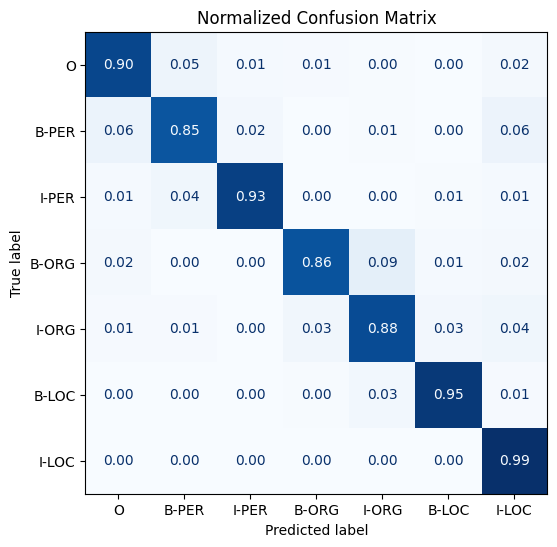

In [16]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()


plot_confusion_matrix(
    df_tokens["pred_labels"], df_tokens["true_labels"], dm.tags.names
)

В основном, модель имеет хорошее качества, что видно по темной диагонали. Но она часта путает `B-ORG` и `I-ORG`.

Теперь посмотрим на предложения с высокой средней ошибкой.

In [17]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        # Проходим по всем элементам, исключая первый и последний (если нужно)
        for i in range(1, (row["tokens"] != "<pad>").sum() - 1):
            labels.append(row["true_labels"][i])
            preds.append(row["pred_labels"][i])
            tokens.append(row["tokens"][i])
            losses.append(f"{row['token_losses'][i]:.2f}")

        df_tmp = pd.DataFrame(
            {
                "tokens": tokens,
                "true_labels": labels,
                "pred_labels": preds,
                "token_losses": losses,
            }
        ).T
        yield df_tmp


df["total_loss"] = df["token_losses"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
tokens,▁Schwa,n,dorf,▁–,▁Cham,▁–,▁Fur,th,▁im,▁Wald,...,▁(,▁als,▁Teil,▁der,▁Fern,verbindung,▁München,▁-,▁Prag,▁)
true_labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,...,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG
pred_labels,B-LOC,I-LOC,I-LOC,O,B-LOC,O,B-LOC,B-LOC,I-LOC,I-LOC,...,O,O,O,O,O,O,I-ORG,O,I-LOC,I-LOC
token_losses,4.23,0.00,0.00,7.63,8.71,7.53,8.13,0.00,5.04,5.58,...,3.90,5.30,7.77,7.37,5.16,0.00,0.93,1.53,2.61,1.45


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de
true_labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN
pred_labels,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG
token_losses,8.68,0.00,0.00,4.82,9.20,9.23,6.23,0.00,7.44,7.65,7.01,3.11,2.28,0.00,0.00,0.02,0.00


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
tokens,▁Im,▁Jahr,▁2006,▁spielt,e,▁sie,▁in,▁einigen,▁Folgen,▁der,...,▁der,▁'',Bro,oke,▁'',▁über,nah,m,▁,.
true_labels,O,O,O,O,IGN,O,O,O,O,O,...,O,O,IGN,IGN,O,O,IGN,IGN,O,IGN
pred_labels,O,O,O,O,O,O,O,O,O,O,...,O,O,B-PER,O,O,O,O,O,O,O
token_losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Можно видеть, что в разметке данных тоже есть ошибки. Наприме, “8. Juli” помечена как организация. Датасеты PAN-X создавался автоматическими способами, поэтому ошибки не удивительны.

Мы говорили, что у скобок и слэшов тоже большие ошибки. Давайте посмотрим.

In [18]:
df_tmp = df.loc[df["tokens"].apply(lambda x: "\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8
tokens,▁German,▁Master,s,▁(,▁S,no,ok,er,▁)
true_labels,B-PER,I-PER,IGN,I-PER,I-PER,IGN,IGN,IGN,I-PER
pred_labels,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
token_losses,3.25,3.82,0.00,3.47,3.30,0.00,0.00,0.00,3.54


,0,1,2,3,4,5
tokens,▁Drag,e,▁(,▁El,be,▁)
true_labels,B-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC
pred_labels,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
token_losses,0.01,0.00,0.01,0.01,0.00,0.01


Как правило, мы не включаем скобки и их содержимое в именованные объекты, однако, по-видимому, алгоритм автоматического извлечения аннотаций работает именно так. В других примерах в скобках указывается географическая принадлежность. Хотя это и является местоположением, нам стоит вынести эту информацию в отдельное поле аннотации. Данный набор данных состоит из многоязычных статей Википедии, где пояснения в скобках — это обычное дело. Например, в первом примере «(Unternehmen)» уточняет, что «Hama» — это компания. Эти детали важно учитывать при внедрении модели, поскольку они могут повлиять на производительность всего конвейера, частью которого она является.

## Обучение на всех языках

До этого мы дообучали модель только на немецком языке и, благодаря cross lingual transfer learning, смогли предсказывать и на других языках.

Вот такие результаты получили.

In [19]:
results

,train_f1,train_loss,val_f1_de,val_f1_en,val_f1_fr,val_f1_it,val_loss_de,val_loss_en,val_loss_fr,val_loss_it
epoch,,,,,,,,,,
4,0.973679,0.019325,0.86197,0.585224,0.702495,0.628935,0.143299,0.974609,0.869035,1.038661


Посмотрим, что будет, если дообучить модель на всех языках

In [20]:
dm.set_train_langs(LANGS)

In [21]:
pl_model = plNERClassifier(
    model_name=MODEL_NAME,
    config=xlmr_config,
    langs=LANGS,
    lr=2e-5,
)

trainer, ckpt_path = get_trainer(train_langs=LANGS)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
with disable_tokenizer_parallelism():
    trainer.fit(pl_model, datamodule=dm, ckpt_path=ckpt_path)
    if ckpt_path:
        print(f"\nМодель загружена из памяти {ckpt_path}")

Restoring states from the checkpoint path at NER/de-fr-it-en/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | XLMRobertaForTokenClassification | 277 M  | eval 
1 | train_f1  | SeqevalF1Metric                  | 0      | train
2 | val_f1_de | SeqevalF1Metric                  | 0      | train
3 | val_f1_fr | SeqevalF1Metric                  | 0      | train
4 | val_f1_it | SeqevalF1Metric                  | 0      | train
5 | val_f1_en | SeqevalF1Metric                  | 0      | train
-----------------------------------------------------------------------
277 M     Trainable params
0         Non-trainable params
277 M     Total params
1,109.834 Total estimated model params size (MB)
5         Modules in train mode
228       Modules in eval mode
Restored

`Trainer.fit` stopped: `max_epochs=5` reached.



Модель загружена из памяти NER/de-fr-it-en/checkpoints/last.ckpt


In [23]:
all_langs_results = get_metrics(
    EXPERIMENTS_PATH / "de-fr-it-en/logs/version_0/metrics.csv"
)
all_langs_results

,train_f1,train_loss,val_f1_de,val_f1_en,val_f1_fr,val_f1_it,val_loss_de,val_loss_en,val_loss_fr,val_loss_it
epoch,,,,,,,,,,
4,0.975209,0.021228,0.861605,0.761855,0.858979,0.841434,0.150952,0.423125,0.273808,0.276041


## Выводы

- Cross Lingual Transfer лучше работает для похожих языков. То есть мы обучили модель на немецком, и получили лучшие результаты на валидации французского и итальянского языков, чем на английском. Немецкий, французский и итальянский ближе друг к другу, чем английский.
- Обучение на всех языках дает лучшее качество. Но если языки схожи, то можно использовать и cross lingual transfer. Например, в японском языке это может быть хорошим решением.